In [1]:
import os

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from NeuralNet import Net

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from data import processing_data
from evatuation import visualize_results
from settings import BASE_DIR, DEVICE
import pandas as pd

In [2]:
data_path = os.path.join(BASE_DIR,"dataset", 'movies_data_processed_v3.csv')

df = pd.read_csv(data_path)

df

,name,genres,rating,no_of_votes,meta_score,release_date,gross,budget,countries,log_budget,log_no_of_votes,log_gross,log_gross_bin
0,Love Hurts,"Martial Arts, Action, Comedy",5.3,6800,34.0,2025.0,17235040.0,18000000.0,United States,16.705882,8.824825,16.662455,3.0
1,The Quick and the Dead,"Action, Drama, Romance, Thriller, Western",6.5,107000,49.0,1995.0,18636537.0,32000000.0,"United States, Japan",17.281246,11.580593,16.740635,3.0
2,Puss in Boots: The Last Wish,"Animal Adventure, Computer Animation, Fairy Ta...",7.8,200000,73.0,2022.0,481757663.0,90000000.0,"United States, Japan",18.315320,12.206078,19.992952,9.0
3,The Fifth Element,"Sci-Fi Epic, Space Sci-Fi, Action, Adventure, ...",7.6,524000,52.0,1997.0,263920180.0,25000000.0,"France, United Kingdom",17.034386,13.169249,19.391157,8.0
4,Superman,"Sci-Fi Epic, Superhero, Urban Adventure, Actio...",7.4,195000,82.0,1978.0,300478449.0,55000000.0,"United States, United Kingdom, Switzerland, Pa...",17.822844,12.180760,19.520887,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079,Far and Away,"Romantic Epic, Western Epic, Adventure, Drama,...",6.6,70000,49.0,1992.0,137783840.0,60000000.0,United States,17.909855,11.156265,18.741197,7.0
2080,Pale Rider,"Drama, Western",7.3,67000,61.0,1985.0,41410568.0,6900000.0,United States,15.747032,11.112463,17.539047,4.0
2081,Shanghai Noon,"Buddy Comedy, Martial Arts, Action, Adventure,...",6.6,138000,77.0,2000.0,99274467.0,55000000.0,"United States, Hong Kong",17.822844,11.835016,18.413399,6.0
2082,The Duel,"Drama, Western",5.8,12000,42.0,2016.0,20672.0,10000000.0,United States,16.118096,9.392745,9.936584,0.0


Fold 1


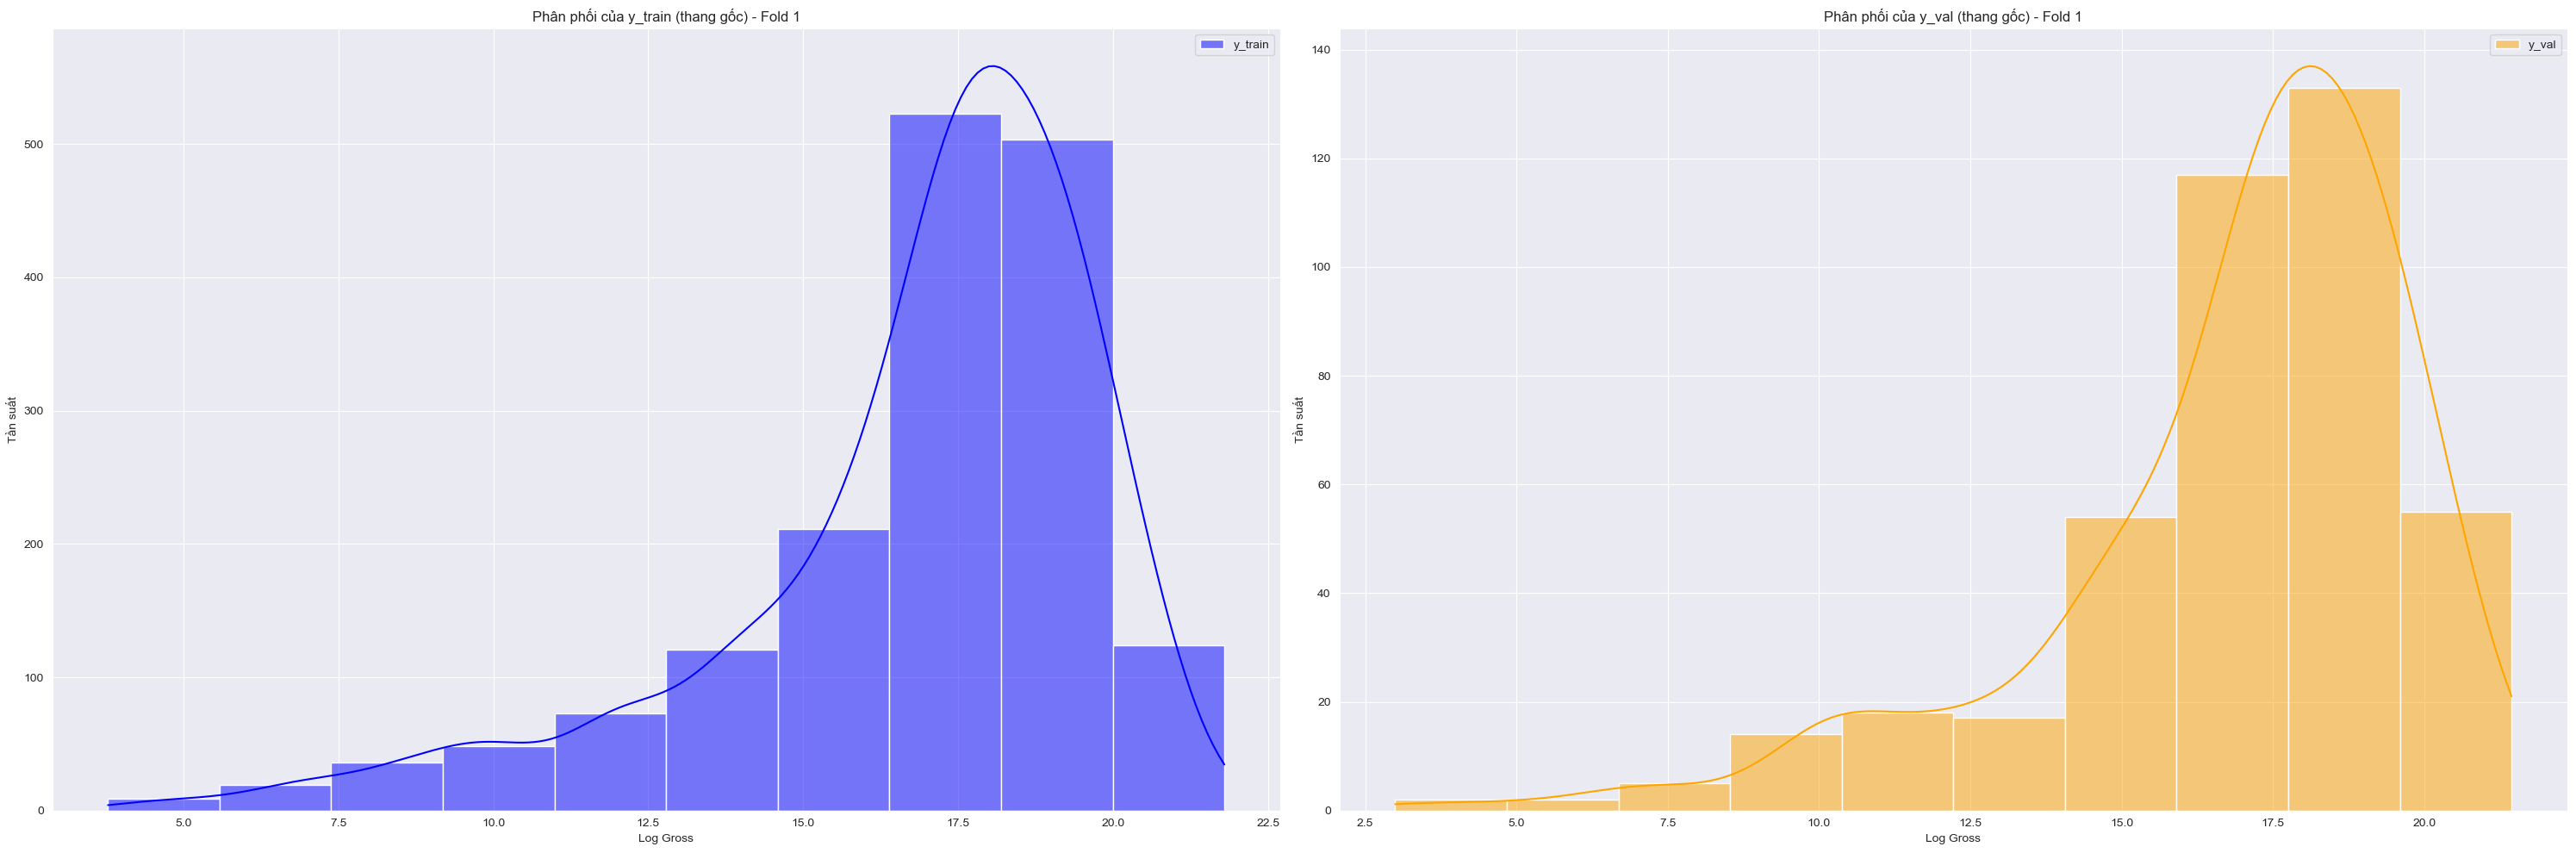

Early stopping at epoch 554


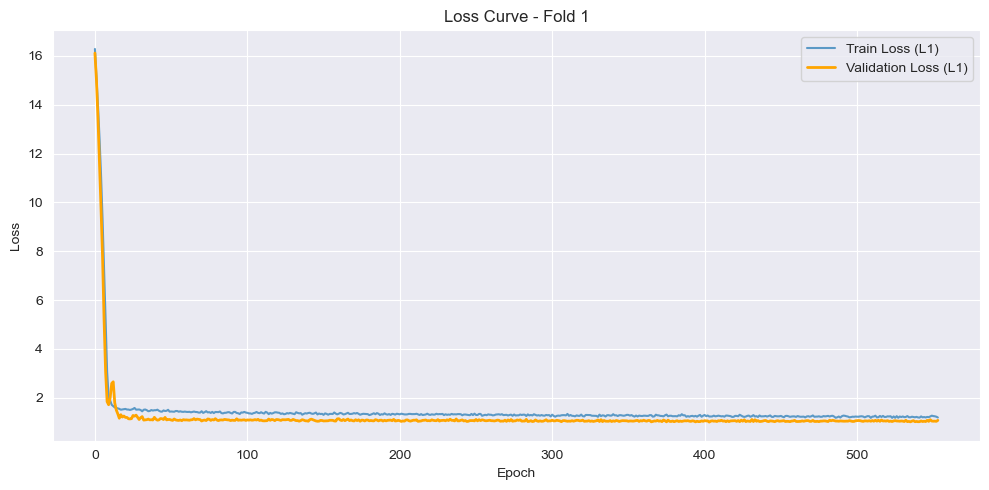

Training Metrics
R2 score: 0.5485
MSE: 32,620,809,189,064,704.0000
MLSE: 3.7169
MAPE: 142.95%
Test Metrics
R2 score: 0.5505
MSE: 26,663,414,671,605,760.0000
MLSE: 3.8199
MAPE: 73.30%


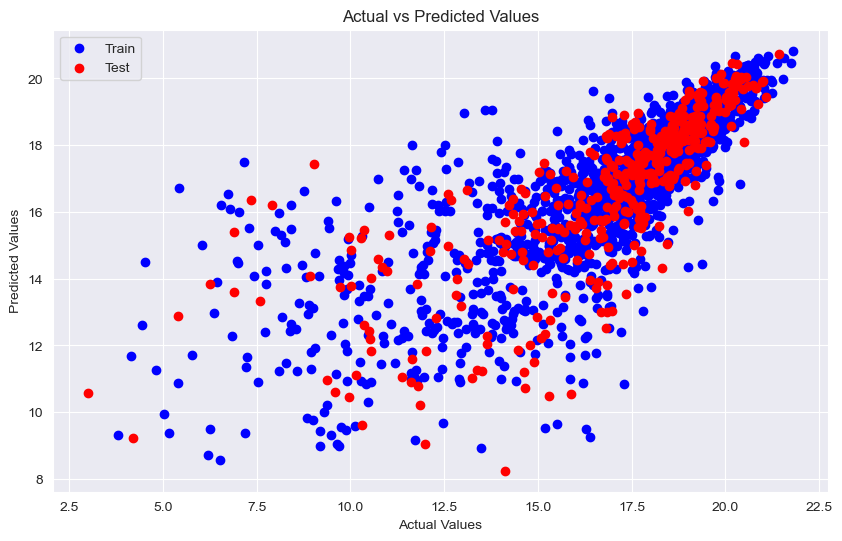

Fold 2


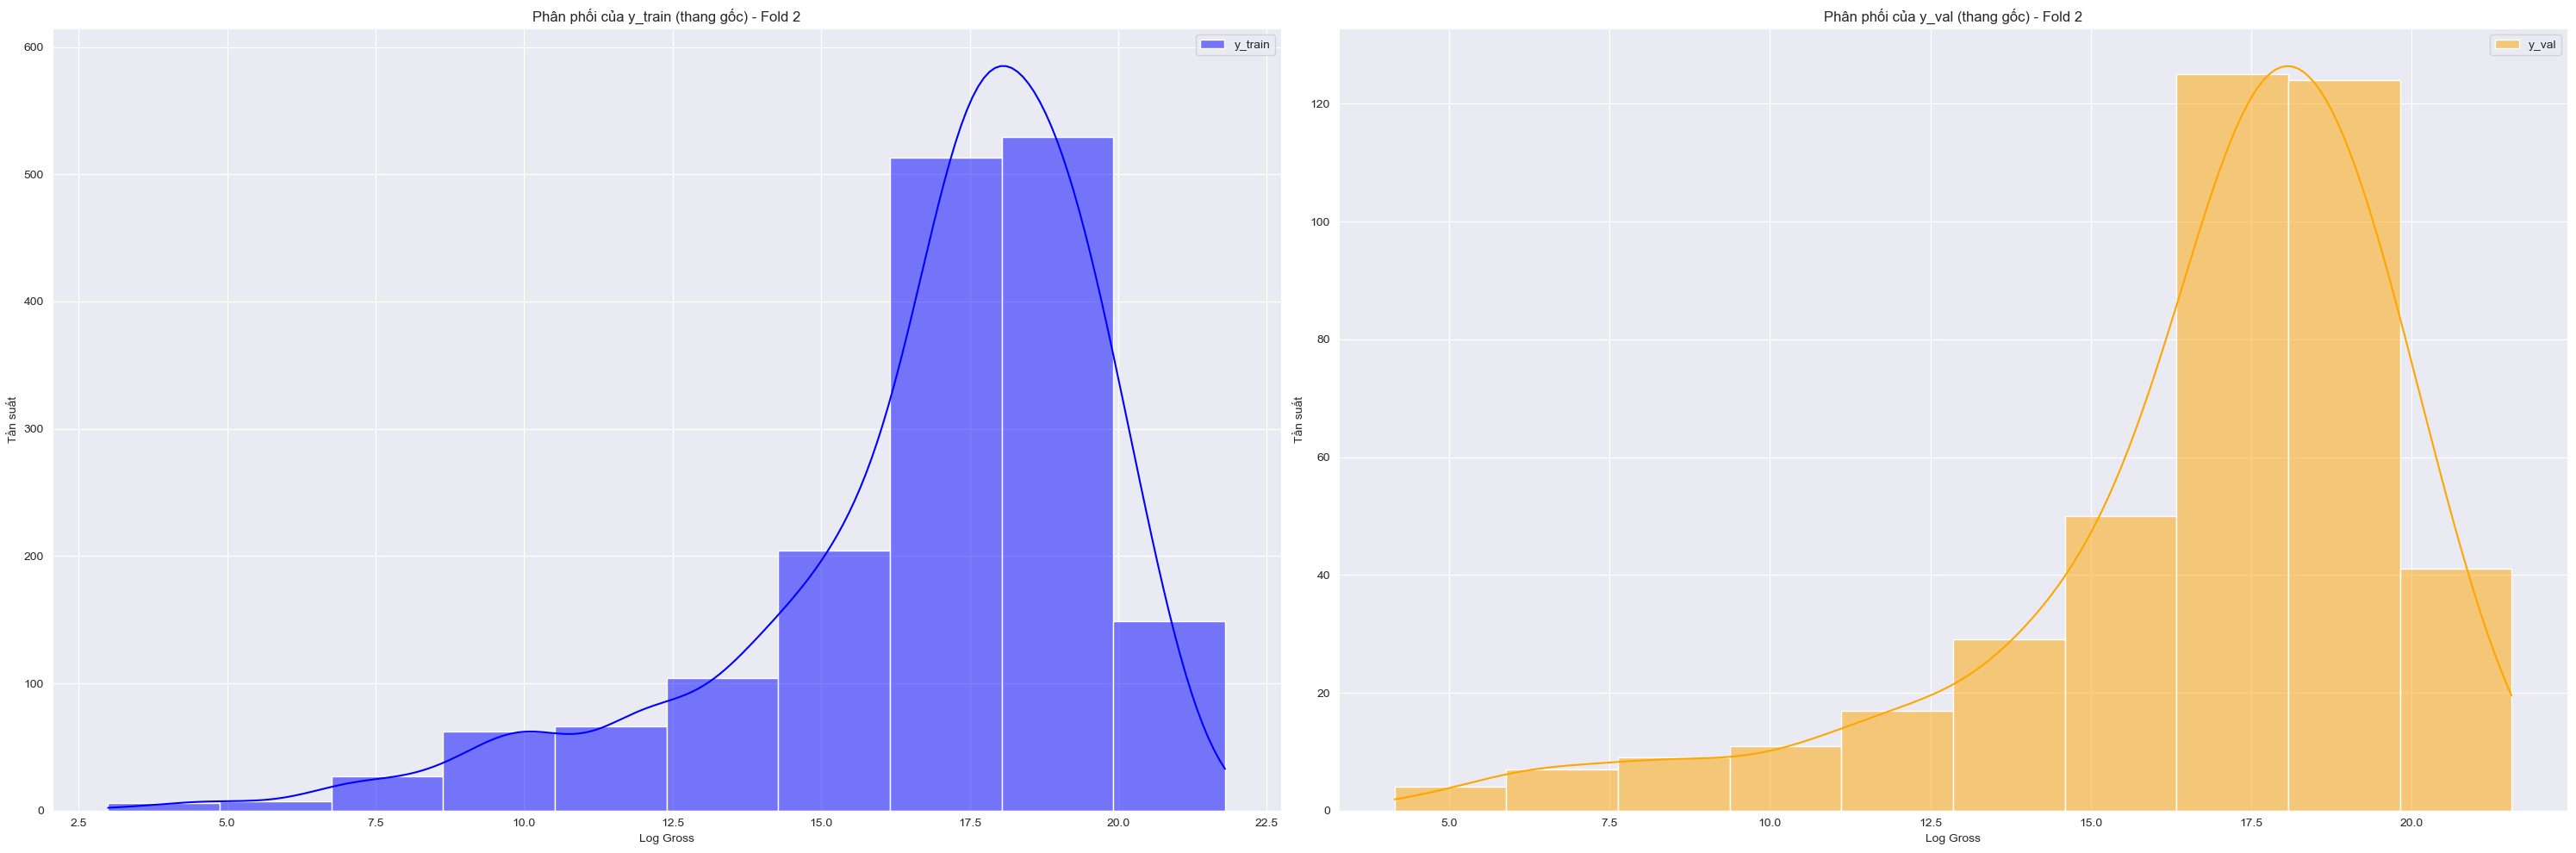

Early stopping at epoch 712


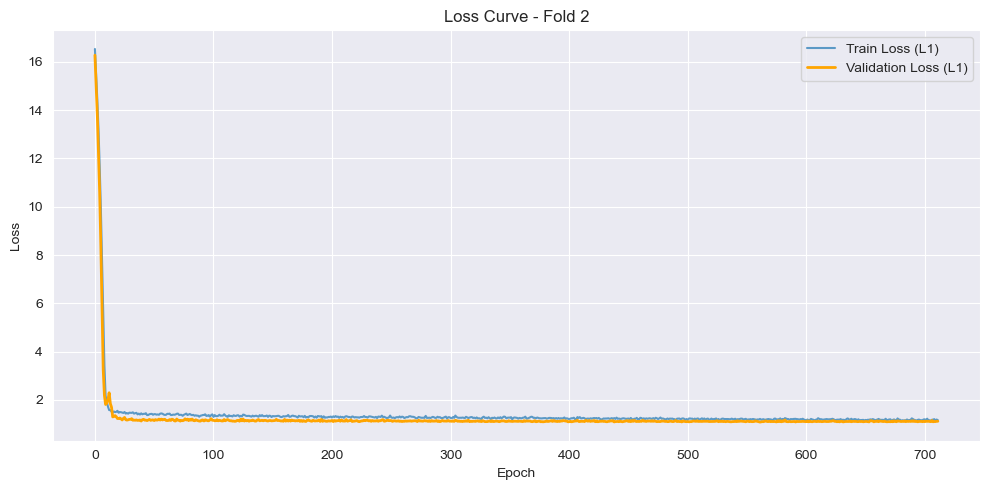

Training Metrics
R2 score: 0.6058
MSE: 26,668,390,391,218,176.0000
MLSE: 3.4668
MAPE: 136.77%
Test Metrics
R2 score: 0.5226
MSE: 37,087,484,982,591,488.0000
MLSE: 4.6863
MAPE: 399.01%


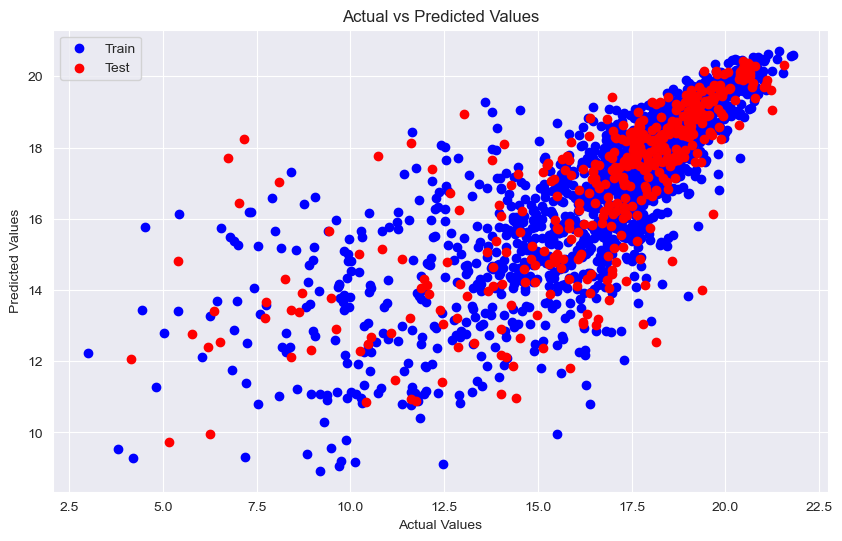

Fold 3


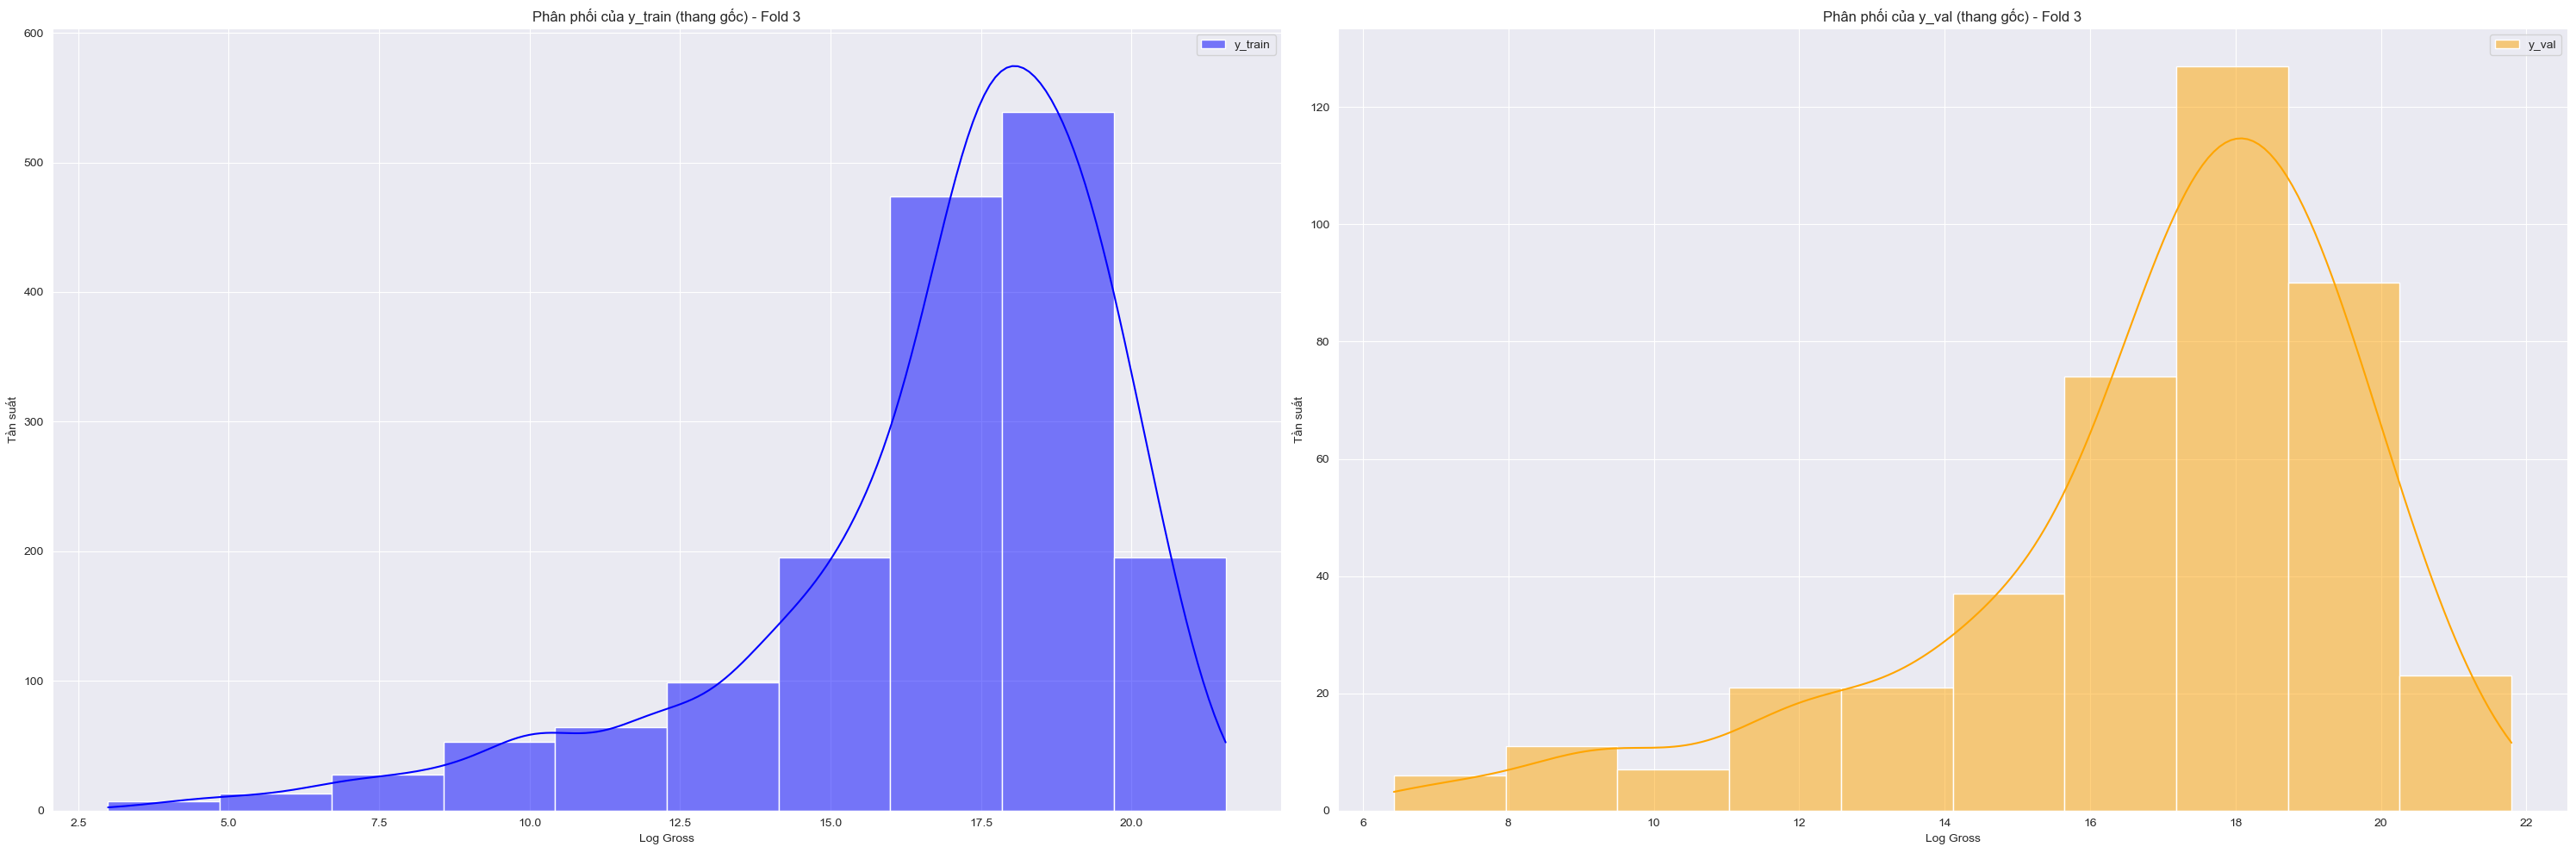

Early stopping at epoch 390


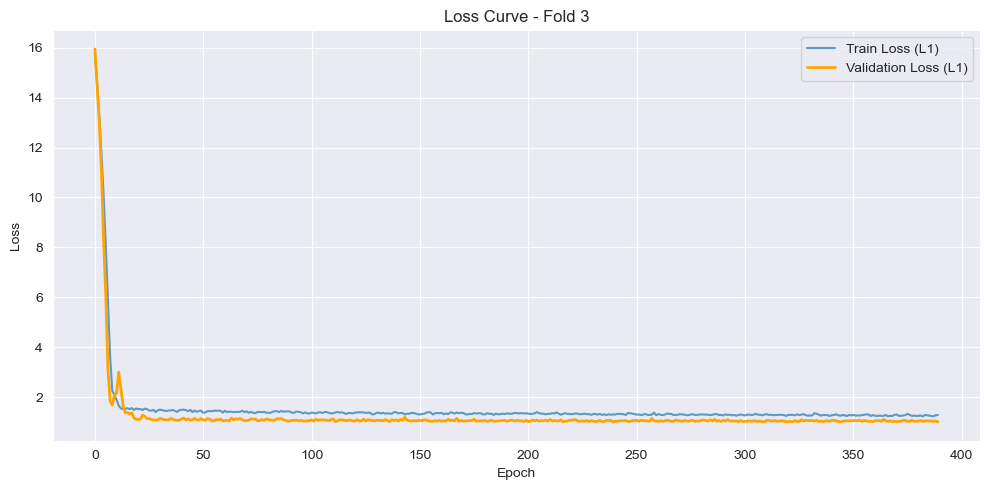

Training Metrics
R2 score: 0.6937
MSE: 19,074,012,038,561,792.0000
MLSE: 3.8244
MAPE: 168.76%
Test Metrics
R2 score: 0.6793
MSE: 31,791,801,044,041,728.0000
MLSE: 3.5000
MAPE: 71.41%


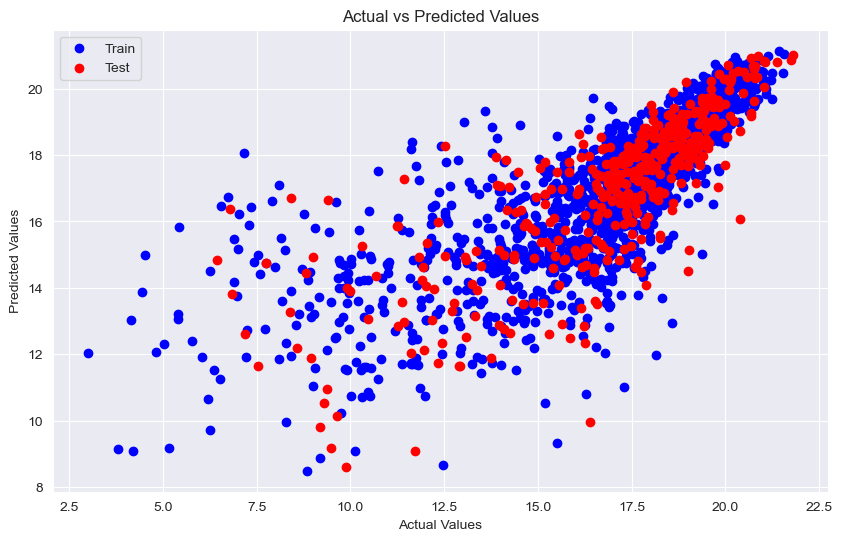

Fold 4


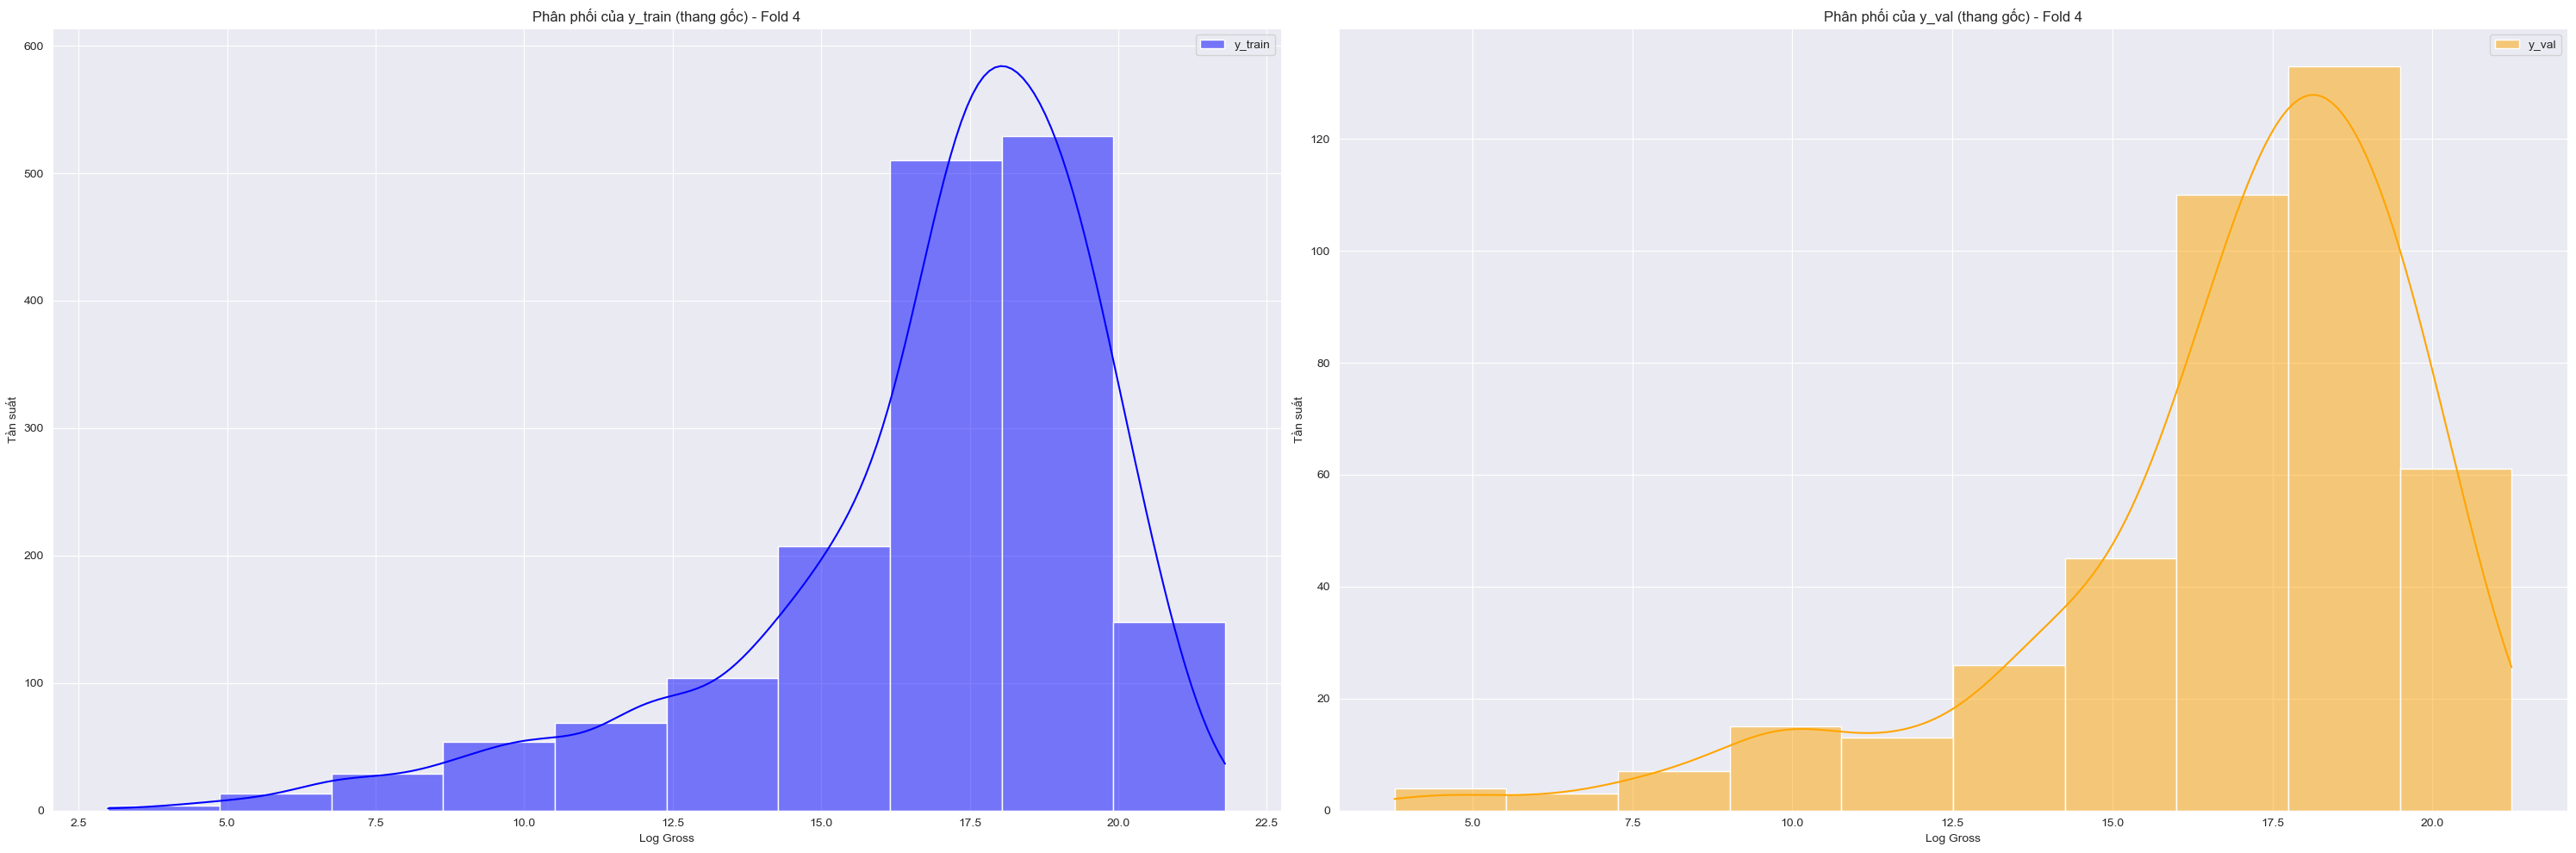

Early stopping at epoch 365


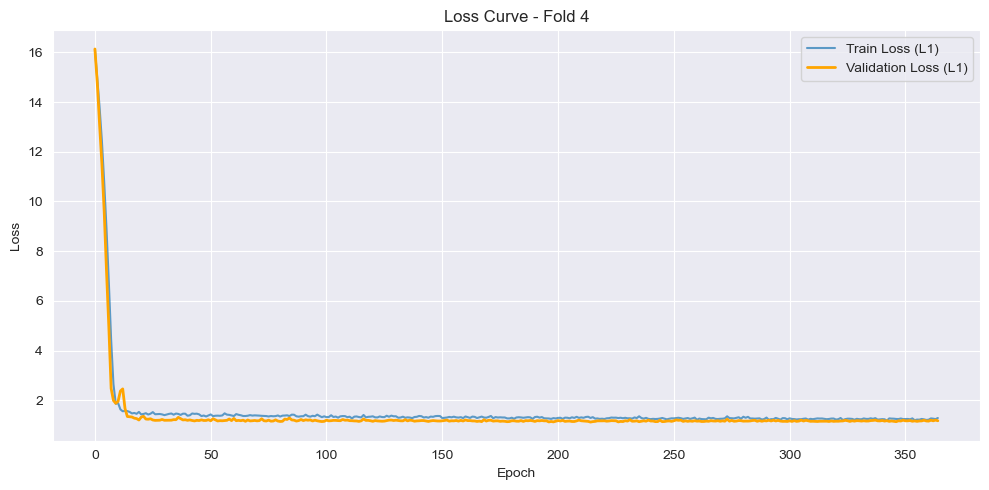

Training Metrics
R2 score: 0.5101
MSE: 36,379,717,321,883,648.0000
MLSE: 3.6149
MAPE: 121.87%
Test Metrics
R2 score: 0.3005
MSE: 35,850,880,146,210,816.0000
MLSE: 4.6979
MAPE: 373.44%


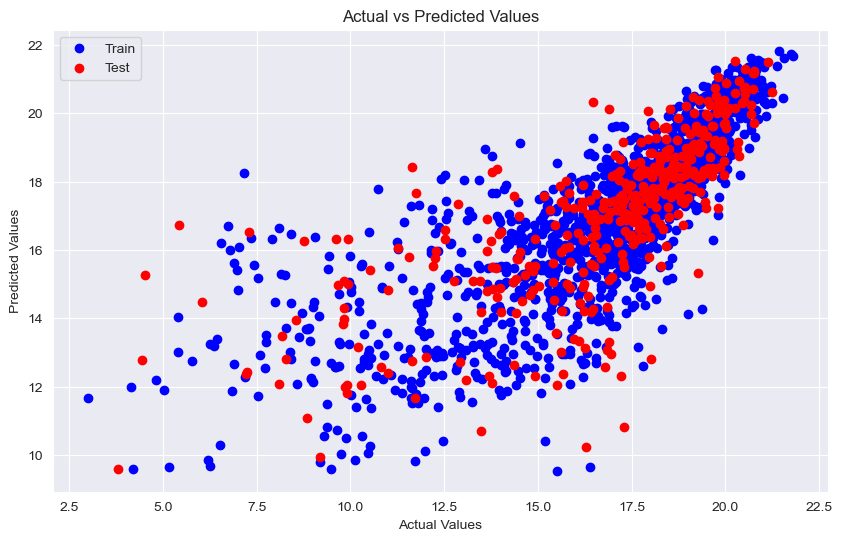

Fold 5


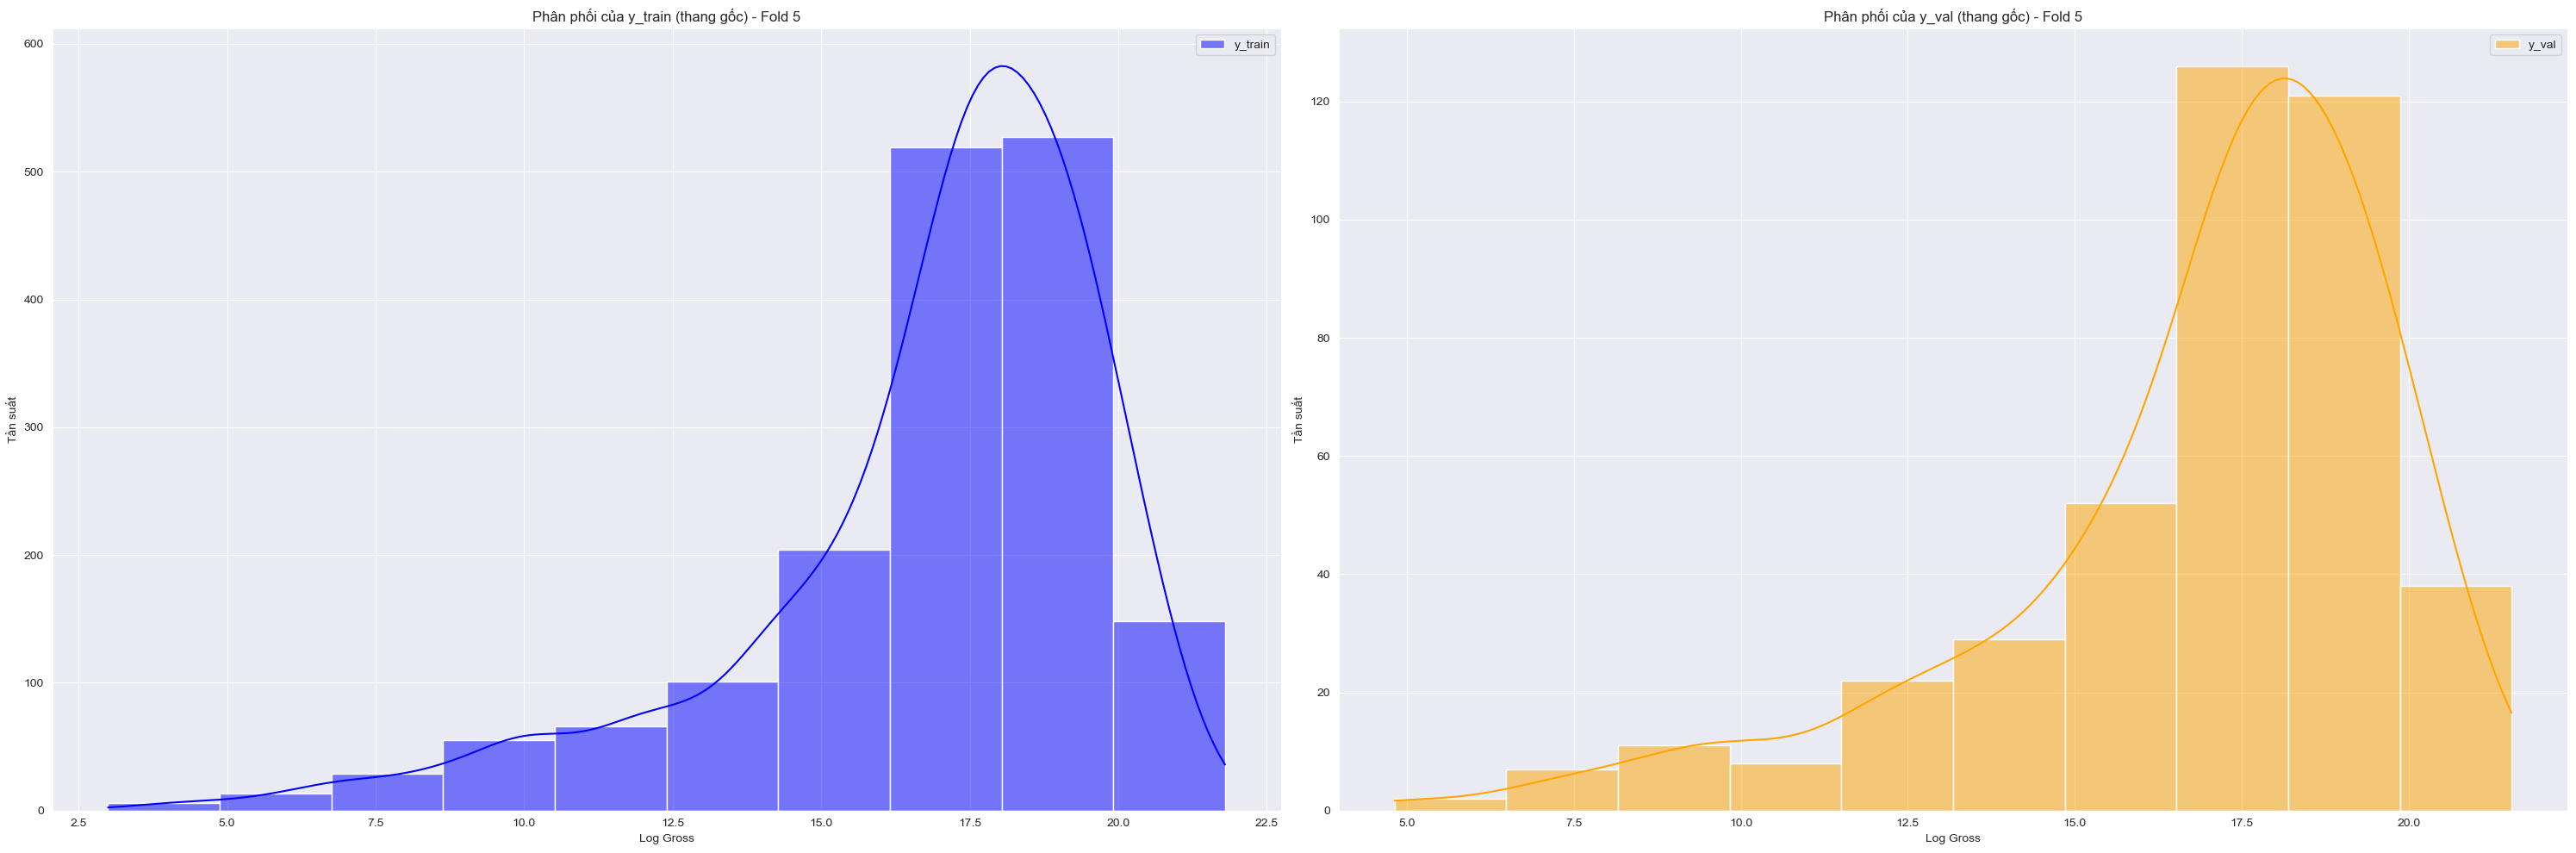

Early stopping at epoch 848


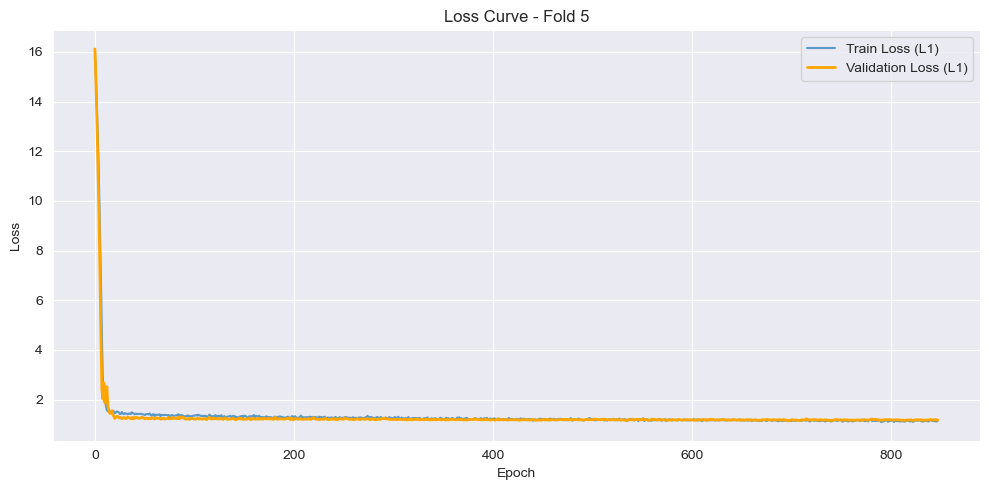

Training Metrics
R2 score: 0.6488
MSE: 25,252,354,706,112,512.0000
MLSE: 3.5030
MAPE: 167.50%
Test Metrics
R2 score: 0.5851
MSE: 25,197,894,520,799,232.0000
MLSE: 4.8431
MAPE: 203.68%


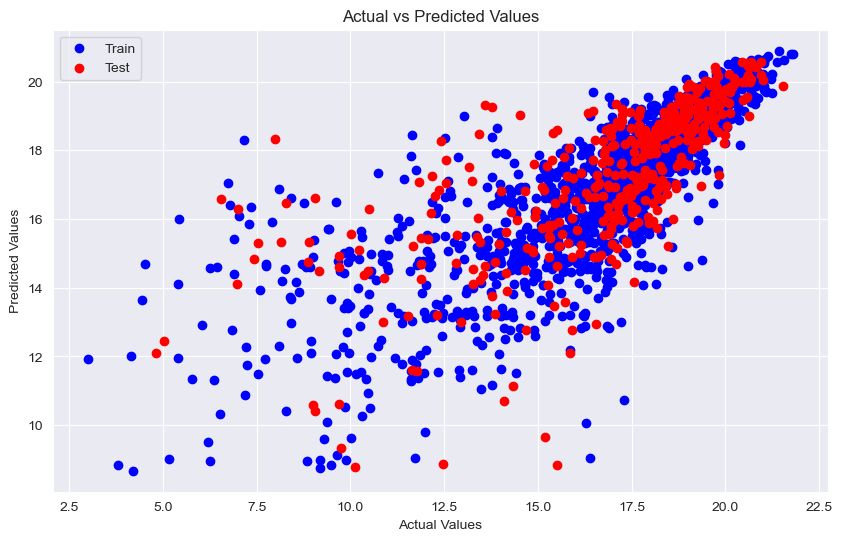

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

PATIENCE = 150
LEARNING_RATE = 0.005
BATCH_SIZE = 256
EPOCHS = 2000

BEST_MODEL_DIR = os.path.join(BASE_DIR, "best_models")
os.makedirs(BEST_MODEL_DIR, exist_ok=True)

all_fold_r2 = []
all_fold_mape = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"Fold {fold + 1}")

    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Tạo DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


    plt.tight_layout()
    plt.show()

    # Khởi tạo mô hình, loss và optimizer
    model = Net(X_train.shape[1]).to(DEVICE)
    criterion = nn.SmoothL1Loss(beta=0.5).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = os.path.join(BEST_MODEL_DIR, f"best_model_fold_{fold + 1}.pt")

    # Huấn luyện
    for epoch in range(EPOCHS):
        model.train()
        epoch_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))


        # Đánh giá
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor.to(DEVICE))
            val_loss = criterion(val_preds, y_val_tensor.to(DEVICE)).item()
            val_losses.append(val_loss)

            # Chuyển sang numpy để tính các metric trên scale gốc
            log_preds = val_preds.cpu().numpy().flatten()
            log_true_vals = y_val_tensor.cpu().numpy().flatten()

            preds = np.expm1(log_preds)
            true_vals = np.expm1(log_true_vals)

            mse = mean_squared_error(true_vals, preds)
            mae = mean_absolute_error(true_vals, preds)
            r2 = r2_score(true_vals, preds)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Vẽ train và val loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_losses)), train_losses, label="Train Loss (L1)", alpha=0.7)
    plt.plot(range(len(val_losses)), val_losses, label="Validation Loss (L1)", color='orange', linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve - Fold {fold + 1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    model.eval()
    with torch.no_grad():
        test_predictions = model(X_val_tensor.to(DEVICE))
        test_predictions = test_predictions.cpu().numpy().flatten()
        y_test = y_val_tensor.cpu().numpy().flatten()

        train_predictions = model(X_train_tensor.to(DEVICE))
        train_predictions = train_predictions.cpu().numpy().flatten()
        y_train = y_train_tensor.cpu().numpy().flatten()


        _, _, _, _, test_r2, test_mse, test_msle, test_mape = visualize_results(y_train, train_predictions, y_test, test_predictions, is_logged=True)

        all_fold_r2.append(test_r2)
        all_fold_mape.append(test_mape)

avg_r2 = np.mean(all_fold_r2)
avg_mape = np.mean(all_fold_mape)

print("\n===== Cross-Validation Average Results =====")
print(f"Avg R²: {avg_r2:.4f} (±{np.std(all_fold_r2):.4f})")
print(f"Avg MAPE Loss: {avg_mape:.4f} (±{np.std(avg_mape):.4f})")

# Optionally, plot average metrics across folds
plt.figure(figsize=(12, 8))
fold_indices = list(range(1, len(all_fold_mape) + 1))

plt.subplot(2, 2, 1)
plt.bar(fold_indices, all_fold_r2)
plt.axhline(y=avg_r2, color='r', linestyle='-', label=f'Average: {avg_r2:.2f}')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('MSE by Fold')
plt.legend()

plt.subplot(2, 2, 2)
plt.bar(fold_indices, all_fold_mape)
plt.axhline(y=avg_mape, color='r', linestyle='-', label=f'Average: {avg_mape:.2f}')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('MAE by Fold')
plt.legend()



plt.tight_layout()
plt.show()


IndentationError: unexpected indent (1031078671.py, line 1)